In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils.convert import to_networkx

In [2]:
# a drawing function:
import matplotlib.pyplot as plt
def draw_G(data):
    G = to_networkx(data)
    pos = nx.spring_layout(G)
    plt.figure(1,figsize=(10,8)) 
    nx.draw_networkx(G, pos, node_color="orange", node_size=800)
    plt.show()

In [3]:
import random
def make_graph_data(nbr_nodes=20, nbr_edges=20):
    #------------ 1. node features tensor --------------------------------------:
    nf = [[i] for i in range(nbr_nodes)] 
    nF = torch.tensor(nf, dtype=torch.float)
    # print(nF)

    #------------ 2. edge list -------------------------------------------------:
    el = []
    node = 0
    for i in range(nbr_edges):
        if node==nbr_nodes:
            node = 0
        a = random.randint(0,nbr_nodes-1)
        el.append([node, a])
        node+=1

    eL = torch.tensor(el, dtype=torch.long)
#     print(eL.tolist())

    #------------ 3. predictions 'y' -------------------------------------------------:
    receiving_nodes = []
    for i in eL.tolist():
        receiving_nodes.append(i[1])
#     print('\n')
#     print(receiving_nodes)

    ocrnce = []
    for i in receiving_nodes:
        ocrnce.append(receiving_nodes.count(i))
#     print('\n')
#     print(ocrnce)   

    ocrncy_of_pair_nodes = []
    ocrncy_of_unpair_nodes = []
    for i, o in enumerate(ocrnce):
        if receiving_nodes[i] % 2 == 0:          #pair
            ocrncy_of_pair_nodes.append(o)
        else:                                    #unpair
            ocrncy_of_unpair_nodes.append(o)

#     print('\n')
#     print(ocrncy_of_pair_nodes)
#     print(ocrncy_of_unpair_nodes)

    if sum(ocrncy_of_pair_nodes) >= sum(ocrncy_of_unpair_nodes):
        y = torch.tensor([1], dtype=torch.long)
    else:
        y = torch.tensor([0], dtype=torch.long)

#     print('\n')
#     print(y)
    
    data = Data(x=nF, edge_index=eL.t().contiguous(), y=y)
    
    return data

In [4]:
dataset = []
nbr_samples = 10000
for i in range(nbr_samples):
    data = make_graph_data(nbr_nodes=20, nbr_edges=20)
    dataset.append(data)
    
len(dataset)
dataset[2]

Data(x=[20, 1], edge_index=[2, 20], y=[1])

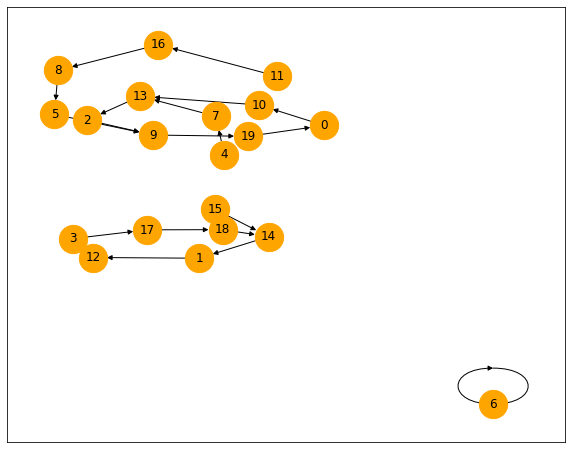

In [5]:
draw_G(dataset[0])

## Give the dataset to a GNN model:

In [6]:
dataset = []
nbr_samples = 10000
for i in range(nbr_samples):
    data = make_graph_data(nbr_nodes=20, nbr_edges=20)
    dataset.append(data)
    
len(dataset)

data = dataset[0]
data

Data(x=[20, 1], edge_index=[2, 20], y=[1])

In [7]:
from torch_geometric.loader import DataLoader

train_dataloader = DataLoader(dataset[0:8000], batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset[8000:10000], batch_size=32, shuffle=True)

In [8]:
for batch in train_dataloader:
    break
    
batch #, batch.x.float(), batch.edge_index, batch.batch

DataBatch(x=[640, 1], edge_index=[2, 640], y=[32], batch=[640], ptr=[33])

In [12]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset[0].num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.out = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        out = self.out(x)

        return out

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
Number of parameters:  321


In [13]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

In [20]:
out = model(batch)
len(out)

640

In [19]:
criterion = torch.nn.CrossEntropyLoss()
target = batch.y.to(torch.float32)  
loss = criterion(out, target)
loss

ValueError: Expected input batch_size (640) to match target batch_size (32).

In [21]:
# Train ------------------------------------------------------------------
# def train(data):
#     for batch in loader:
#         batch.to(device)  
#         optimizer.zero_grad()
#         pred, embedding = model(batch) 
#         loss = loss_fn(pred, batch.y)     
#         loss.backward()  
#         optimizer.step()   
#     return loss.item()

In [22]:
# model.eval()
# pred = model(data).argmax(dim=1)